In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

# Download necessary data
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sunny\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sunny\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# Sample dataset
data = [
    ("Win a lottery now!", "spam"),
    ("Hello, how are you?", "ham"),
    ("Congratulations! You won a free vacation!", "spam"),
    ("Are we still on for the meeting?", "ham"),
    ("Claim your prize by clicking here!", "spam"),
    ("Let's grab coffee tomorrow.", "ham")
]

# Tokenization & stopwords removal
stop_words = set(stopwords.words('english'))

In [6]:
def preprocess(text):
    tokens = word_tokenize(text.lower())
    return [word for word in tokens if word.isalpha() and word not in stop_words]

# Processed dataset
processed_data = [(preprocess(text), label) for text, label in data]


In [7]:
# Convert words to indices
vocab = set(word for sentence, _ in processed_data for word in sentence)
word_to_idx = {word: i+1 for i, word in enumerate(vocab)}  # +1 for padding

# Convert dataset to tensor format
def encode_sentence(sentence, word_to_idx, max_len=10):
    encoded = [word_to_idx.get(word, 0) for word in sentence]
    return encoded + [0] * (max_len - len(encoded))


In [8]:
X = torch.tensor([encode_sentence(sentence, word_to_idx) for sentence, _ in processed_data])
y = torch.tensor([1 if label == "spam" else 0 for _, label in processed_data], dtype=torch.float32)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [9]:
class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(GRUClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size + 1, embed_dim)  # Word embedding
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        embedded = self.embedding(x)
        _, hidden = self.gru(embedded)
        out = self.fc(hidden.squeeze(0))
        return self.sigmoid(out)

# Model Parameters
model = GRUClassifier(vocab_size=len(word_to_idx), embed_dim=16, hidden_dim=32, output_dim=1)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.01)


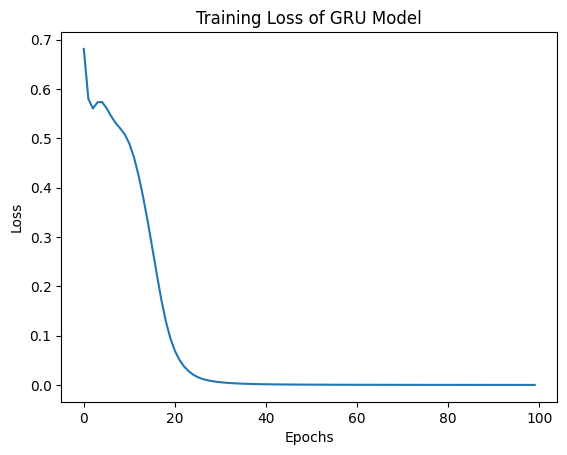

In [10]:
epochs = 100
losses = []

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train).squeeze()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

# Plot Training Loss
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss of GRU Model")
plt.show()


In [11]:
with torch.no_grad():
    predictions = model(X_test).squeeze()
    predictions = (predictions >= 0.5).float()
    accuracy = (predictions == y_test).float().mean()
    print(f"Test Accuracy: {accuracy.item() * 100:.2f}%")


Test Accuracy: 50.00%


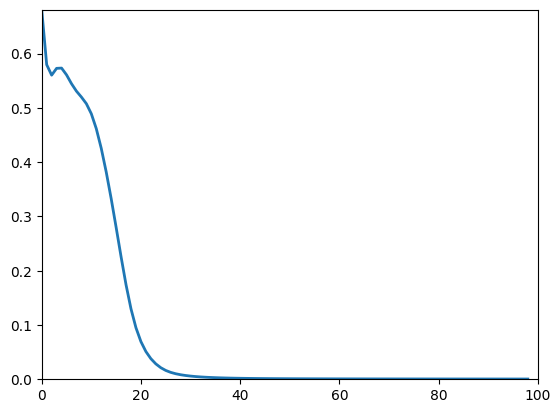

In [12]:
fig, ax = plt.subplots()
ax.set_xlim(0, epochs)
ax.set_ylim(0, max(losses))
line, = ax.plot([], [], lw=2)

def animate(i):
    line.set_data(range(i), losses[:i])
    return line,

ani = animation.FuncAnimation(fig, animate, frames=epochs, interval=100, blit=True)
ani.save("gru_training.gif", writer="pillow")


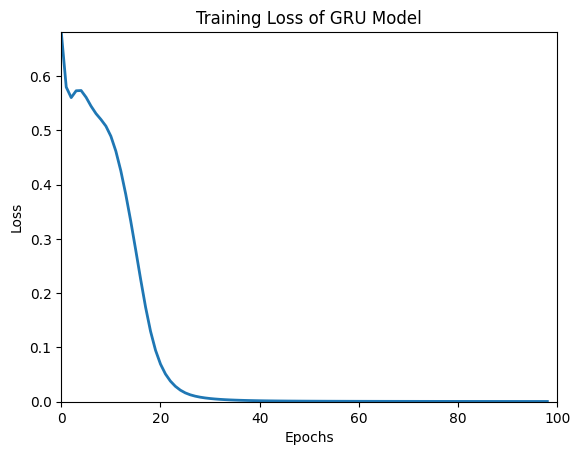

In [13]:
fig, ax = plt.subplots()
ax.set_xlim(0, epochs)
ax.set_ylim(0, max(losses))
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Training Loss of GRU Model")
line, = ax.plot([], [], lw=2)

def animate_loss(i):
    line.set_data(range(i), losses[:i])
    return line,

ani_loss = animation.FuncAnimation(fig, animate_loss, frames=epochs, interval=100, blit=True)
ani_loss.save("gru_training_loss.gif", writer="pillow")


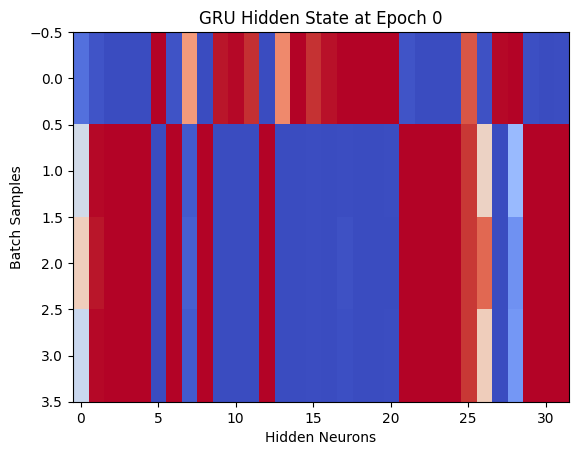

In [14]:
import numpy as np

fig, ax = plt.subplots()
hidden_states = []

# Capture hidden states
for epoch in range(epochs):
    with torch.no_grad():
        _, hidden = model.gru(model.embedding(X_train))
        hidden_states.append(hidden.squeeze(0).numpy())

def animate_hidden(i):
    ax.clear()
    ax.imshow(hidden_states[i], cmap="coolwarm", aspect="auto")
    ax.set_title(f"GRU Hidden State at Epoch {i}")
    ax.set_xlabel("Hidden Neurons")
    ax.set_ylabel("Batch Samples")

ani_hidden = animation.FuncAnimation(fig, animate_hidden, frames=epochs, interval=100, blit=False)
ani_hidden.save("gru_hidden_states.gif", writer="pillow")


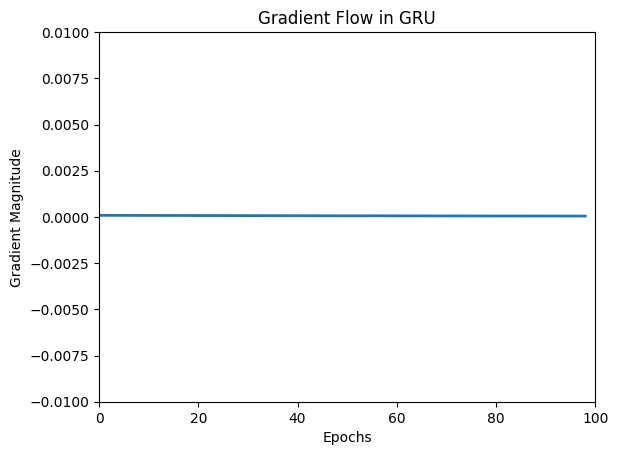

In [15]:
fig, ax = plt.subplots()
ax.set_xlim(0, epochs)
ax.set_ylim(-0.01, 0.01)
ax.set_xlabel("Epochs")
ax.set_ylabel("Gradient Magnitude")
ax.set_title("Gradient Flow in GRU")

gradients = []

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train).squeeze()
    loss = criterion(outputs, y_train)
    loss.backward()
    
    grad_magnitude = []
    for param in model.parameters():
        if param.grad is not None:
            grad_magnitude.append(param.grad.abs().mean().item())
    
    gradients.append(np.mean(grad_magnitude))
    optimizer.step()

line, = ax.plot([], [], lw=2)

def animate_grad(i):
    line.set_data(range(i), gradients[:i])
    return line,

ani_grad = animation.FuncAnimation(fig, animate_grad, frames=epochs, interval=100, blit=True)
ani_grad.save("gru_gradient_flow.gif", writer="pillow")
